In [5]:
#Load up modules
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection


In [20]:
#load up graph and graph settings (x/y axis)
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
# this was throwing an error in the last cell
#     plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax

In [55]:
#load csv dataset and plot it
dflog = pd.read_csv("COVID19_line_list_data.csv", usecols=['gender', 'id', 'age', 'death', 'visiting_Wuhan'])
dflog.head()

,id,gender,age,visiting_Wuhan,death
0,1,male,66,1,0
1,2,female,56,0,0
2,3,male,46,0,0
3,4,female,60,1,0
4,5,male,58,0,0


<AxesSubplot:xlabel='age', ylabel='death'>

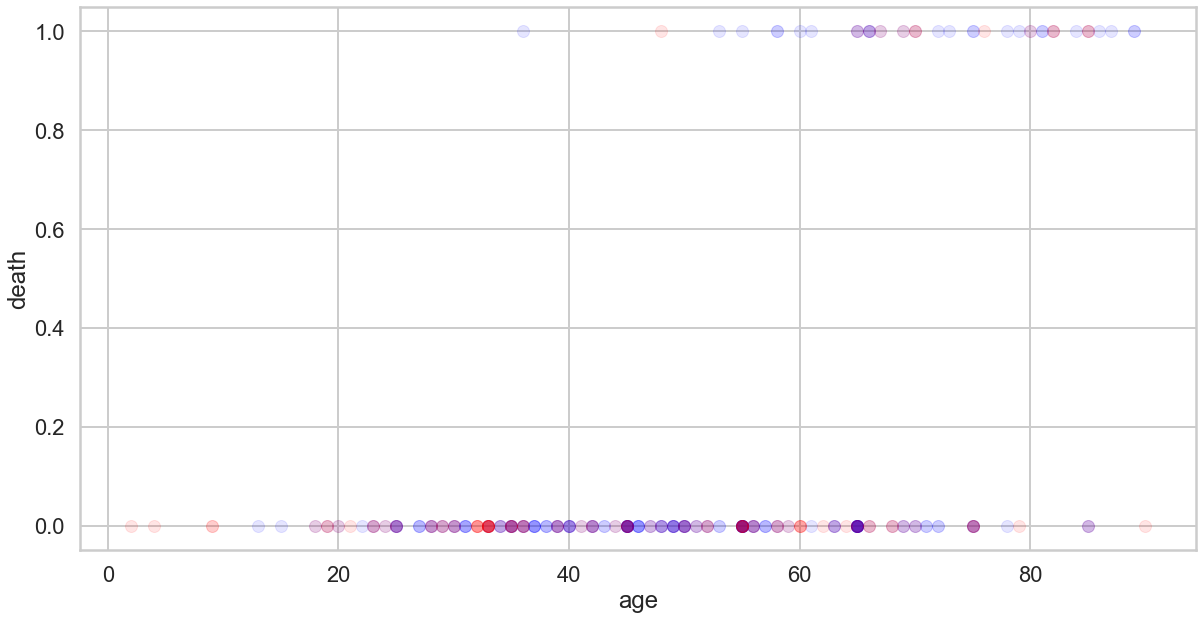

In [56]:
f, ax = plt.subplots(figsize=(20, 10))
# plot male
dflog_m = dflog[dflog.gender == "male"]
dflog_f = dflog[dflog.gender != "male"]
#plot the observation for age to death ratio
sns.regplot(x=dflog_m.age, y=dflog_m.death, ax=ax, fit_reg=False, color="b", scatter_kws={"alpha":0.1})
sns.regplot(x=dflog_f.age, y=dflog_f.death, ax=ax, fit_reg=False, color="r", scatter_kws={"alpha":0.1})

In [57]:
# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['age','death']].values, 
                                              (dflog.gender == "male").values,random_state=5)

clf = LogisticRegression(solver="lbfgs")
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.6153846153846154


In [58]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [59]:
clf = LogisticRegression(solver="lbfgs")
score = cv_score(clf, Xlr, ylr)
print(score)

0.6597594819611471


In [60]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

pairs = { "C": 0, "score": 0}
# 
for c in Cs:
    lr = LogisticRegression(solver="lbfgs", C=c)
    lr.fit(Xlr, ylr)
    score = cv_score(lr, Xlr, ylr)
    print(f'C value {c} score {score}')
    if score > pairs['score']:
        pairs['C'] = c
        pairs['score'] = score
print(f'Found best C {pairs["C"]} with highest score of {pairs["score"]}')

C value 0.001 score 0.6640148011100833
C value 0.1 score 0.6640148011100833
C value 1 score 0.6597594819611471
C value 10 score 0.6597594819611471
C value 100 score 0.6597594819611471
Found best C 0.001 with highest score of 0.6640148011100833


In [61]:
#Evaluate accuracy of model
lr = LogisticRegression(solver="lbfgs", C=0.1)
lr.fit(Xlr, ylr)
score = accuracy_score(lr.predict(Xtestlr), ytestlr)
print(f'Accuracy of model: {score}')

Accuracy of model: 0.6153846153846154
